# Logistic Regression on BRCA subset of the TCGA dataset (only with LumA and LumB)
#### Using Logistic Regression for breast cancer subtype classification

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, mutual_info_classif
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

import seaborn as sn
import matplotlib.pyplot as plt

## Load and split the dataset

In [3]:
# Training set
X_train = pd.read_csv("data/ciriello_brca_filtered.csv")
X_train = X_train[(X_train.Ciriello_subtype != "Normal") & 
                  (X_train.Ciriello_subtype != "Her2") & 
                  (X_train.Ciriello_subtype != "Basal")]
y_train = X_train["Ciriello_subtype"]

X_train.drop(['Ciriello_subtype'], axis="columns", inplace=True)

# Final test set
X_test = pd.read_csv("data/brca_final_test.csv")
X_test = X_test[(X_test.subtype != "Normal") & 
                (X_test.subtype != "Her2") &
                 (X_test.subtype != "Basal")]
y_test = X_test["subtype"]

X_test.drop(['subtype'], axis="columns", inplace=True)

# Order the features correctly

X_train = X_train.reindex(sorted(X_train.columns), axis="columns")
X_test = X_test.reindex(sorted(X_test.columns), axis="columns")

### Scale the data

In [4]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

## Code to tune parameter C

In [5]:
values=[0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
i=1
results = pd.DataFrame(columns=["Index", "C", "Accuracy"])
mean_scores = []

for it in range(2):
    print('Iteration {}/2 of 5-Fold Cross-Validation'.format(it+1))
    skf = StratifiedKFold(n_splits=5)
    for c in values:
        scores = []

        for train_index, test_index in skf.split(X_train_scaled, y_train):

            X_cv_train, X_cv_val = X_train_scaled.iloc[train_index], X_train_scaled.iloc[test_index]
            y_cv_train, y_cv_val = y_train.iloc[train_index], y_train.iloc[test_index]

            clf = LogisticRegression(random_state=0, solver='liblinear', penalty="l1", C=c, multi_class="auto").fit(X_cv_train, y_cv_train)

            score = clf.score(X_cv_val, y_cv_val)
            results = results.append({'Fold': i, 'C' : c , 'Score' : score}, ignore_index=True)
            scores.append(score)
            i+=1

        i=1
        mean_scores.append(np.mean(scores))
        print('Results: {}'.format(scores))
        print('C: {}, Accuracy: {}'.format(c, np.mean(scores)))
        
#results.to_csv("parameter_tuning/logisticRegression_C_tuning_.csv", index=False)
mean_scores

Iteration 1/2 of 5-Fold Cross-Validation
Results: [0.6974789915966386, 0.7033898305084746, 0.7033898305084746, 0.7033898305084746, 0.7033898305084746]
C: 0.001, Accuracy: 0.7022076627261074
Results: [0.6974789915966386, 0.7033898305084746, 0.7033898305084746, 0.7033898305084746, 0.7033898305084746]
C: 0.01, Accuracy: 0.7022076627261074
Results: [0.8067226890756303, 0.788135593220339, 0.8898305084745762, 0.9067796610169492, 0.8559322033898306]
C: 0.1, Accuracy: 0.8494801310354649
Results: [0.907563025210084, 0.847457627118644, 0.8983050847457628, 0.940677966101695, 0.8898305084745762]
C: 1, Accuracy: 0.8967668423301525
Results: [0.9243697478991597, 0.8559322033898306, 0.8898305084745762, 0.9152542372881356, 0.8983050847457628]
C: 10, Accuracy: 0.8967383563594931
Results: [0.9243697478991597, 0.8813559322033898, 0.9067796610169492, 0.9152542372881356, 0.923728813559322]
C: 100, Accuracy: 0.9102976783933914
Results: [0.907563025210084, 0.8728813559322034, 0.923728813559322, 0.915254237288

[0.7022076627261074,
 0.7022076627261074,
 0.8494801310354649,
 0.8967668423301525,
 0.8967383563594931,
 0.9102976783933914,
 0.9018515880928643,
 0.8815695769833358,
 0.7022076627261074,
 0.7022076627261074,
 0.8494801310354649,
 0.8967668423301525,
 0.8967383563594931,
 0.9102976783933914,
 0.9018515880928643,
 0.8815695769833358]

### We can see that C=100 is the best parameter, hence why we'll use it to test our model

In [6]:
clf = LogisticRegression(random_state=0, solver='liblinear', penalty="l1", C=100, multi_class="auto").fit(X_train, y_train)

In [7]:
final_score = clf.score(X_test_scaled, y_test)
print('Confusion matrix\n', confusion_matrix(y_test, clf.predict(X_test_scaled)))
print('Accuracy', final_score)

Confusion matrix
 [[120  11]
 [  3  29]]
Accuracy 0.9141104294478528


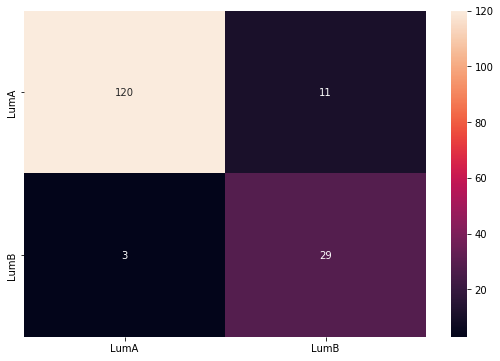

In [10]:
#How do I know the order of the labels???
import matplotlib.pyplot as plt
conf_matrix = pd.DataFrame(confusion_matrix(y_test, clf.predict(X_test_scaled)), index = ["LumA", "LumB"], columns = ["LumA", "LumB"])
plt.figure(figsize=(9, 6))
sn.heatmap(conf_matrix, annot=True, fmt='g')
#conf_matrix.to_csv("results/tcga_log_res_confusion_matrix.csv")

# Let's try to use the 5k more "influential"

## With mutual_info_classif

In [11]:
selector = SelectKBest(mutual_info_classif, k=5000).fit(X_train_scaled, y_train)
relevant_idx = selector.get_support()
relevant_genes = X_train_scaled.columns[relevant_idx]

### Load and split the dataset

In [12]:
X_train_relevant = X_train_scaled[relevant_genes]
X_test_relevant = X_test_scaled[relevant_genes]

### Tune parameter C

In [13]:
values=[0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
i=1
results = pd.DataFrame(columns=["Index", "C", "Accuracy"])
mean_scores = []

skf = StratifiedKFold(n_splits=5)

for c in values:
    scores = []
    
    for train_index, test_index in skf.split(X_train_relevant, y_train):

        X_cv_train, X_cv_val = X_train_relevant.iloc[train_index], X_train_relevant.iloc[test_index]
        y_cv_train, y_cv_val = y_train.iloc[train_index], y_train.iloc[test_index]

        clf = LogisticRegression(random_state=0, solver='liblinear', penalty="l1", C=c, multi_class="auto").fit(X_cv_train, y_cv_train)
        
        score = clf.score(X_cv_val, y_cv_val)
        results = results.append({'Fold': i, 'C' : c , 'Score' : score}, ignore_index=True)
        scores.append(score)
        i+=1
        
    i=1
    mean_scores.append(np.mean(scores))
    print('5-Fold results: {}'.format(scores))
    print('C: {}, Accuracy: {}'.format(c, np.mean(scores)))
        
#results.to_csv("parameter_tuning/logisticRegression_C_tuning_5k_mutual_info.csv", index=False)
mean_scores

5-Fold results: [0.6974789915966386, 0.7033898305084746, 0.7033898305084746, 0.7033898305084746, 0.7033898305084746]
C: 0.001, Accuracy: 0.7022076627261074
5-Fold results: [0.6974789915966386, 0.7033898305084746, 0.7033898305084746, 0.7033898305084746, 0.7033898305084746]
C: 0.01, Accuracy: 0.7022076627261074
5-Fold results: [0.8067226890756303, 0.7796610169491526, 0.8983050847457628, 0.9152542372881356, 0.8983050847457628]
C: 0.1, Accuracy: 0.8596496225608888
5-Fold results: [0.8991596638655462, 0.864406779661017, 0.8898305084745762, 0.940677966101695, 0.8983050847457628]
C: 1, Accuracy: 0.8984760005697195
5-Fold results: [0.8991596638655462, 0.8305084745762712, 0.923728813559322, 0.940677966101695, 0.9152542372881356]
C: 10, Accuracy: 0.901865831078194
5-Fold results: [0.8907563025210085, 0.864406779661017, 0.9067796610169492, 0.9491525423728814, 0.9152542372881356]
C: 100, Accuracy: 0.9052699045719983
5-Fold results: [0.8991596638655462, 0.8983050847457628, 0.9152542372881356, 0.940

[0.7022076627261074,
 0.7022076627261074,
 0.8596496225608888,
 0.8984760005697195,
 0.901865831078194,
 0.9052699045719983,
 0.913730237857855,
 0.8985187295257087]

### Train the Model

In [14]:
clf_5k = LogisticRegression(random_state=0, solver='liblinear', penalty="l1", C=1000, multi_class="auto").fit(X_train_relevant, y_train)

In [15]:
final_score = clf.score(X_test_relevant, y_test)
print('Confusion matrix\n', confusion_matrix(y_test, clf.predict(X_test_relevant)))
print('Accuracy', final_score)

Confusion matrix
 [[104  27]
 [  1  31]]
Accuracy 0.8282208588957055


In [16]:
#How do I know the order of the labels???
import matplotlib.pyplot as plt
conf_matrix = pd.DataFrame(confusion_matrix(y_test, clf.predict(X_test_relevant)), index = ["Basal", "Her2", "LumA", "LumB"], columns = ["Basal", "Her2", "LumA", "LumB"])
plt.figure(figsize=(9, 6))
sn.heatmap(conf_matrix, annot=True, fmt='g')
#conf_matrix.to_csv("results/tcga_log_res_confusion_matrix_5k_mutual_info.csv")

ValueError: Shape of passed values is (2, 2), indices imply (4, 4)

## With chi2

In [5]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [6]:
selector = SelectKBest(chi2, k=5000).fit(X_train_scaled, y_train)
relevant_idx = selector.get_support()
relevant_genes = X_train_scaled.columns[relevant_idx]

In [7]:
X_train_relevant = X_train_scaled[relevant_genes]
X_test_relevant = X_test_scaled[relevant_genes]

In [8]:
### Tune parameter C

In [9]:
values=[0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
i=1
results = pd.DataFrame(columns=["Index", "C", "Accuracy"])
mean_scores = []

skf = StratifiedKFold(n_splits=5)

for c in values:
    scores = []
    
    for train_index, test_index in skf.split(X_train_relevant, y_train):

        X_cv_train, X_cv_val = X_train_relevant.iloc[train_index], X_train_relevant.iloc[test_index]
        y_cv_train, y_cv_val = y_train.iloc[train_index], y_train.iloc[test_index]

        clf = LogisticRegression(random_state=0, solver='liblinear', penalty="l1", C=c, multi_class="auto").fit(X_cv_train, y_cv_train)
        
        score = clf.score(X_cv_val, y_cv_val)
        results = results.append({'Fold': i, 'C' : c , 'Score' : score}, ignore_index=True)
        scores.append(score)
        i+=1
        
    i=1
    mean_scores.append(np.mean(scores))
    print('5-Fold results: {}'.format(scores))
    print('C: {}, Accuracy: {}'.format(c, np.mean(scores)))
        
#results.to_csv("parameter_tuning/logisticRegression_C_tuning_5k_chi2.csv", index=False)
mean_scores

5-Fold results: [0.175, 0.17088607594936708, 0.17088607594936708, 0.17088607594936708, 0.17088607594936708]
C: 0.001, Accuracy: 0.17170886075949368
5-Fold results: [0.51875, 0.5316455696202531, 0.5253164556962026, 0.5253164556962026, 0.5253164556962026]
C: 0.01, Accuracy: 0.5252689873417722
5-Fold results: [0.78125, 0.7784810126582279, 0.879746835443038, 0.8607594936708861, 0.8354430379746836]
C: 0.1, Accuracy: 0.8271360759493671
5-Fold results: [0.8625, 0.8670886075949367, 0.8987341772151899, 0.9493670886075949, 0.8924050632911392]
C: 1, Accuracy: 0.8940189873417722
5-Fold results: [0.86875, 0.8670886075949367, 0.9050632911392406, 0.9367088607594937, 0.879746835443038]
C: 10, Accuracy: 0.8914715189873418
5-Fold results: [0.88125, 0.8860759493670886, 0.8987341772151899, 0.9177215189873418, 0.879746835443038]
C: 100, Accuracy: 0.8927056962025317
5-Fold results: [0.85, 0.8734177215189873, 0.9050632911392406, 0.9050632911392406, 0.8924050632911392]
C: 1000, Accuracy: 0.8851898734177215
5-

[0.17170886075949368,
 0.5252689873417722,
 0.8271360759493671,
 0.8940189873417722,
 0.8914715189873418,
 0.8927056962025317,
 0.8851898734177215,
 0.8725949367088607]

In [10]:
clf_5k = LogisticRegression(random_state=0, solver='liblinear', penalty="l1", C=100, multi_class="auto").fit(X_train_relevant, y_train)

In [11]:
final_score = clf.score(X_test_relevant, y_test)
print('Confusion matrix\n', confusion_matrix(y_test, clf.predict(X_test_relevant)))
print('Accuracy', final_score)

Confusion matrix
 [[ 40   1   1   1]
 [  0  12   1   3]
 [  0   0 127   4]
 [  0   0  14  18]]
Accuracy 0.8873873873873874


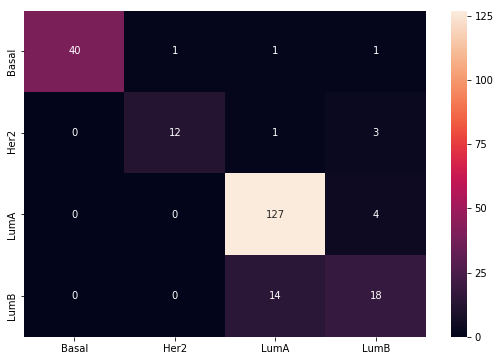

In [12]:
#How do I know the order of the labels???
import matplotlib.pyplot as plt
conf_matrix = pd.DataFrame(confusion_matrix(y_test, clf.predict(X_test_relevant)), index = ["Basal", "Her2", "LumA", "LumB"], columns = ["Basal", "Her2", "LumA", "LumB"])
plt.figure(figsize=(9, 6))
sn.heatmap(conf_matrix, annot=True, fmt='g')
#conf_matrix.to_csv("results/tcga_log_res_confusion_matrix_5k_chi2.csv")

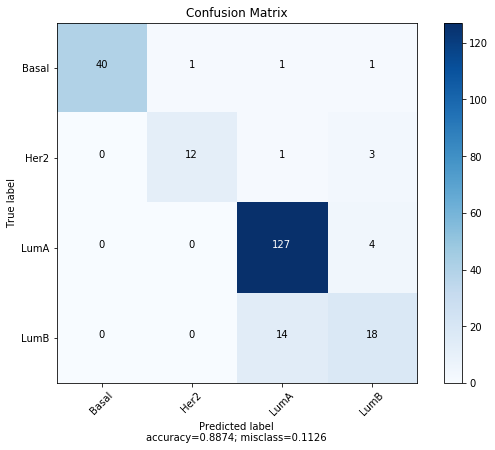

In [13]:
plot_confusion_matrix(cm           = confusion_matrix(y_test, clf.predict(X_test_relevant)), 
                      normalize    = False,
                      target_names = ["Basal", "Her2", "LumA", "LumB"],
                      title        = "Confusion Matrix")